In [ ]:
import json
import random

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv("../data/raw/gtsrb-german-traffic-sign/Train.csv")
test_df = pd.read_csv("../data/raw/gtsrb-german-traffic-sign/Test.csv")

In [3]:
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [4]:
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [5]:
# Filter the columns out
train_df = train_df[["Path", "ClassId"]]
test_df = test_df[["Path", "ClassId"]]

In [6]:
# Check for missing values
train_df.isna().sum()

Path       0
ClassId    0
dtype: int64

In [7]:
# Addthe full path to the images
train_df["Path"] = "gtsrb-german-traffic-sign/" + train_df["Path"]
test_df["Path"] = "gtsrb-german-traffic-sign/" + test_df["Path"]

In [ ]:
train_df.head(2)

,Path,ClassId
0,gtsrb-german-traffic-sign/Train/20/00020_00000...,20
1,gtsrb-german-traffic-sign/Train/20/00020_00000...,20


In [35]:
# Read the labels
with open ("../src/preprocess/labels.json", "r") as file:
    label_names = json.load(file)

In [46]:
label_names['labels']['0']

'Speed limit(20km/h)'

image shape : (47, 46, 3)
Image label: No passing for vehicles over 3.5 metric tons


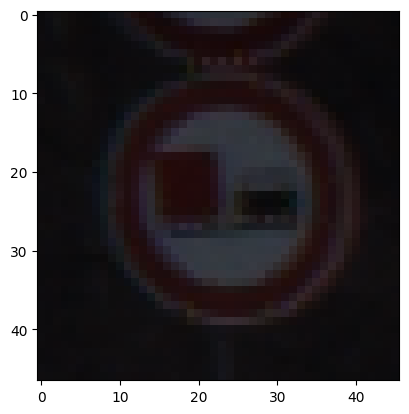

In [56]:
# Visualization
random_img_path = random.choice(train_df["Path"])
img_path = "../data/raw/" + random_img_path

img = plt.imread(img_path)
print(f'image shape : {img.shape}')
print(f'Image label: {label_names['labels'][str(train_df[train_df["Path"] == random_img_path]["ClassId"].values[0])]}')
plt.imshow(plt.imread(img_path))

In [57]:
# Check the min shape and the max shape
train_df["Path"].apply(lambda x: plt.imread("../data/raw/" + x).shape).min()

(25, 25, 3)

# Preprocessing the images

In [130]:
from sklearn.model_selection import train_test_split

import torch
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [407]:
# Preprocess the images
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the data
train_data = datasets.ImageFolder("../data/raw/gtsrb-german-traffic-sign/Train", transform=transform)
train, valid = train_test_split(train_data, test_size=0.2, random_state=42)

# Create the dataloaders
train_loader = DataLoader(train, batch_size=32, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid, batch_size=32, pin_memory=True)

In [408]:
class CustomTestDataset():
    def __init__(self, data, transform=None):
        # self.data = pd.read_csv(PATH)
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load the img and its label
        img_path = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]

        # Open the imgage to convert it to a tensor
        img_path = "../data/raw/" + img_path # this is only for the notebook
        image = Image.open(img_path).convert("RGB")

        # Apply the transform
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

In [409]:
test_df[test_df.Path == "gtsrb-german-traffic-sign/Test/03445.png"]

,Path,ClassId
3445,gtsrb-german-traffic-sign/Test/03445.png,1


In [410]:
test = CustomTestDataset(test_df, transform=transform)
test_loader = DataLoader(test, batch_size=32, shuffle=True)

In [411]:
img, label = next(iter(test_loader))

In [412]:
X_train, y_train = next(iter(train_loader))
X_valid, y_valid = next(iter(valid_loader))
X_test, y_test = next(iter(test_loader))

In [413]:
def get_batches(loader):
    for data, label in loader:
        yield data.numpy(), label.numpy()

In [414]:
train_data = get_batches(train_loader)
valid_data = get_batches(valid_loader)
test_data = get_batches(test_loader)

In [356]:
# Check the shape (channels, height, width)
X_train[0].shape

torch.Size([3, 32, 32])

In [358]:
# we need shape (height, width, channels) to plot the image
X_train[0].permute(1,2,0).shape

torch.Size([32, 32, 3])

In [359]:
label_names['labels']['0']

'Speed limit(20km/h)'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7411594..2.64].


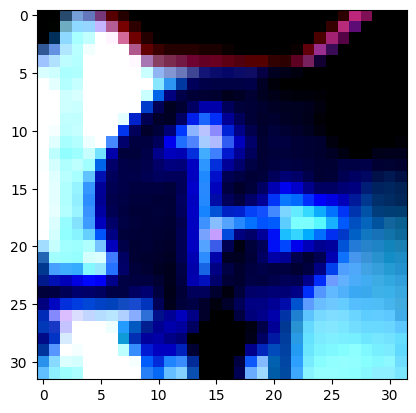

In [209]:
plt.imshow(X_train[1].permute(1,2,0))

In [210]:
# Convert the tensors to numpy arrays (for JAX)
X_train, y_train, X_valid, y_valid, X_test, y_test = X_train.numpy(), y_train.numpy(), X_valid.numpy(), y_valid.numpy(), X_test.numpy(), y_test.numpy()

# Training the model

In [376]:
next(iter(train_loader))

[tensor([[[[-1.4329, -1.5699, -1.6727,  ..., -1.7240, -1.8268, -1.8439],
           [-1.3302, -1.4843, -1.6384,  ..., -1.7412, -1.8439, -1.8610],
           [-1.2617, -1.4329, -1.6213,  ..., -1.7925, -1.8610, -1.8610],
           ...,
           [-1.3987, -1.3815, -1.3473,  ..., -1.7069, -1.7412, -1.7583],
           [-1.3815, -1.3987, -1.3815,  ..., -1.7069, -1.7240, -1.7240],
           [-1.3302, -1.3987, -1.4158,  ..., -1.7754, -1.7583, -1.7412]],
 
          [[-1.4405, -1.5630, -1.6681,  ..., -1.6681, -1.7556, -1.7731],
           [-1.3354, -1.4755, -1.6155,  ..., -1.6856, -1.7731, -1.7731],
           [-1.2829, -1.4230, -1.5980,  ..., -1.7381, -1.7731, -1.7556],
           ...,
           [-1.3354, -1.3179, -1.3004,  ..., -1.6331, -1.6506, -1.6506],
           [-1.3004, -1.3179, -1.2829,  ..., -1.6155, -1.6155, -1.6155],
           [-1.2479, -1.3004, -1.3004,  ..., -1.6681, -1.6506, -1.6331]],
 
          [[-1.2293, -1.3339, -1.4384,  ..., -1.3861, -1.4559, -1.4907],
           [-

In [338]:
# Using Jax to train the model
import numpy as np
import matplotlib.pyplot as plt
import jax
from jax import numpy as jnp
import optax
from tqdm.auto import tqdm
import flax
from flax import linen as nn
from flax.training import train_state

jax.local_devices()

[CudaDevice(id=0)]

In [415]:
num_class = len(label_names['labels'])

class CNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        # (batch_size, height, width, channels)  # JAX Default (NHWC) (32, 32, 32, 3)
        # (batch_size, channels, height, width)  # PyTorch Default (NCHW) (32, 3, 32, 32)
        x = nn.Conv(features=32, kernel_size=(3, 3), kernel_init=nn.initializers.glorot_uniform())(x)
        x = nn.relu(x)
        # print(f"Conv 1: {x.shape}")
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        # print(f"Conv 2: {x.shape}")
        # SAME" Padding → Adds padding to preserve spatial size as much as possible.
        x = nn.max_pool(x, window_shape=(2, 2), padding="SAME") 
        # print(f"Max_pooling 1: {x.shape}")
        x = nn.max_pool(x, window_shape=(2, 2), padding="SAME")
        # print(f"Max_pooling 2: {x.shape}")
        x = nn.Conv(features=128, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        # print(f"Conv 3: {x.shape}")
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        # print(f"Conv 4: {x.shape}")
        x = nn.max_pool(x, window_shape=(2, 2), strides=(1, 1), padding="SAME")
        # print(f"Max_pooling 3: {x.shape}")
        x = x.reshape((x.shape[0], -1))
        # print(x.shape)
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(num_class)(x)
        return x

In [416]:
IMG_SIZE = 32
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key, 2)

# Initialize the model
model = CNN()
inp = jnp.ones((1, IMG_SIZE, IMG_SIZE, 3))
params = model.init(subkey, inp)

# Test the model
model.apply(params, inp)

Array([[-0.0787003 ,  0.01451692,  0.11750038,  0.01783869, -0.05693348,
        -0.04845878, -0.07644345, -0.02904444,  0.04981893,  0.03263966,
        -0.02943162, -0.01088481, -0.09024361,  0.09057917,  0.00949449,
         0.04771358,  0.06192609,  0.04573862,  0.04655391,  0.01153273,
        -0.08767347,  0.08798464, -0.00479038, -0.07925534,  0.06522293,
        -0.08873121,  0.02635204, -0.12824886,  0.03288998,  0.07589898,
         0.0586621 , -0.05629456,  0.01169246,  0.00089401, -0.00859249,
        -0.03198883,  0.03610817,  0.07428332, -0.01952838,  0.03830341,
         0.04792878,  0.05729175, -0.0145327 ]], dtype=float32)

In [417]:
# Training State for JAX CNN Model
learning_rate = 1e-4

optimizer = optax.adam(learning_rate=learning_rate)
model_state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimizer
)

In [418]:
# JAX Metrics
def compute_loss_acc(state, params, batch):
    input, labels = batch
    input = jnp.transpose(input, (0, 2, 3, 1))  # Ensure NHWC format

    logits = state.apply_fn(params, input)

    # 🚨 Clip logits to prevent numerical instability
    logits = jnp.clip(logits, -10, 10)

    # Convert integer labels to one-hot inside the traced function
    num_classes = logits.shape[-1]
    labels = jax.nn.one_hot(labels, num_classes)  # Apply within JIT-traced context

    print("Logits shape:", logits.shape)  # Debugging
    print("Labels shape after one-hot:", labels.shape)

    loss = optax.softmax_cross_entropy(logits, labels).mean()

    # 🚨 Check for NaNs in loss
    if jnp.isnan(loss):
        print("🚨 NaN detected in loss!")

    acc = jnp.mean(jnp.argmax(logits, -1) == jnp.argmax(labels, -1))

    return loss, acc

# Test the function
batch = next(iter(train_data))
compute_loss_acc(model_state, model_state.params, batch)

Logits shape: (32, 43)
Labels shape after one-hot: (32, 43)


(Array(3.7920609, dtype=float32), Array(0.0625, dtype=float32))

In [ ]:
# JAX CNN training
@jax.jit
def train_step(state, batch):
    # Gradient function
    grad_fn = jax.value_and_grad(
        compute_loss_acc, # Function to calculate the loss
        argnums=1, # Parameters are second argument of the function
        has_aux=True # Function has additional outputs, here accuracy
    )

    # Determine gradients for current model, parameters and batch
    (loss, acc), grads = grad_fn(state, state.params, batch)

    # 🚨 Replace NaNs with zeros in gradients
    grads = jax.tree_map(lambda g: jnp.nan_to_num(g, nan=0.0, posinf=1.0, neginf=-1.0), grads)

    # 🚀 Apply Gradient Clipping
    grads, _ = optax.clip_by_global_norm(grads, max_norm=1.0)

    # Perform params update
    state = state.apply_gradients(grads=grads)

    # Return the updated state and the loss
    return state, loss, acc

@jax.jit
def eval_step(state, batch):
    # Determine the accuracy of the model
    loss, acc = compute_loss_acc(state, state.params, batch)
    return loss, acc

train_acc, train_loss, test_acc, test_loss = [], [], [], []

def train_model(state, train_loader, valid_loader, num_epochs=20):
    # training loop
    for epoch in range(num_epochs):
        train_batch_loss, train_batch_acc = [], []
        val_batch_loss, val_batch_acc = [], []

        for train_batch in train_loader:
            state, loss, acc = train_step(state, train_batch)
            # 🚨 Move NaN Check OUTSIDE JIT
            if np.isnan(loss):
                print("🚨 NaN detected in loss!")
            train_batch_loss.append(loss)
            train_batch_acc.append(acc)

        for val_batch in valid_loader:
            val_loss, val_acc = eval_step(state, val_batch)
            val_batch_loss.append(val_loss)
            val_batch_acc.append(val_acc)

        # Calculate the mean loss and accuracy for the train
        epoch_train_loss = np.mean(train_batch_loss)
        epoch_train_acc = np.mean(train_batch_acc)

        # Calculate the mean loss and accuracy for the validation set
        epoch_val_loss = np.mean(val_batch_loss)
        epoch_val_acc = np.mean(val_batch_acc)

        # Append the loss and accuracy
        train_acc.append(epoch_train_acc)
        train_loss.append(epoch_train_loss)
        test_acc.append(epoch_val_acc)
        test_loss.append(epoch_val_loss)


        print(
            f"Epoch: {epoch + 1}, loss: {epoch_train_loss}, acc: {epoch_train_acc}, val_loss: {epoch_val_loss}, val_acc: {epoch_val_acc}"
        )

    return state

In [421]:
train_model(model_state, train_data, valid_data, num_epochs=200)

Logits shape: (32, 43)
Labels shape after one-hot: (32, 43)


TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function train_step at /tmp/ipykernel_1465/2129499099.py:2 for jit. This concrete value was not available in Python because it depends on the values of the arguments state.params['params']['Conv_0']['bias'], state.params['params']['Conv_0']['kernel'], state.params['params']['Conv_1']['bias'], state.params['params']['Conv_1']['kernel'], state.params['params']['Conv_2']['bias'], state.params['params']['Conv_2']['kernel'], state.params['params']['Conv_3']['bias'], state.params['params']['Conv_3']['kernel'], state.params['params']['Dense_0']['bias'], state.params['params']['Dense_0']['kernel'], state.params['params']['Dense_1']['bias'], state.params['params']['Dense_1']['kernel'], batch[0], and batch[1].
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError